In [1]:
import math
import numpy as np
import random
from scipy.stats import beta
import collections
import pandas as pd
from tqdm import tqdm

In [2]:
#utils
def binomial_likelihood(p, n, y):
    return (math.factorial(n) / (math.factorial(y) * math.factorial(n - y))) * math.pow(p, y) * math.pow(1 - p, n - y)
    

def get_workers_accuracy(acc):
    return sum(acc) / len(acc)

In [72]:
class Workers:

    def __init__(self, workers_num, cheaters_prop, fixed_acc = False, workers_acc = .5):
        self.workers_num = workers_num
        self.cheaters_prop = cheaters_prop
        self.acc_passed = []
        self.fixed_acc = fixed_acc
        self.workers_acc = workers_acc

    # simulate workers
    def simulate_workers(self):
        for _ in range(self.workers_num):
            if (self.fixed_acc == False):
                if np.random.binomial(1, self.cheaters_prop):
                    # worker_type is 'rand_ch'
                    worker_acc_pos = 0.5
                else:
                    # worker_type is 'worker'
                    worker_acc_pos = 0.8 + (np.random.beta(1, 1) * 0.2)
            else:
                worker_acc_pos = self.workers_acc
            
            self.acc_passed.append(worker_acc_pos)
        #end for
            
        return self.acc_passed

In [4]:
class Classificator:
    def classification_fn_posterior(votes, prior, accuracy):    
        n = len(votes)
        y = sum(votes.values())

        likelihood = binomial_likelihood(prior, n, y)

        #bayes theorem
        posterior = (likelihood * prior) / ((likelihood * prior) + (1 - accuracy) * (1 - prior))

        return posterior
    
    def classification_fn_beta_pdf(votes, th, accuracy):    
        n = len(votes)
        y = sum(votes.values())

        posterior = beta.sf(th, 1 + y, 1 + (n - y))

        return posterior
    
    def classification_fn_mv(votes):
        n = len(votes)
        s = sum(votes.values())

        return sum(votes.values()) / len(votes)

In [ ]:
class Metrics:

    @staticmethod
    def compute_metrics(items, gt, lr):
        # obtain ground_truth scope values for items

        #fp = false inclusion
        #fn = false exlusion
        fp = fn = tp = tn = 0. 

        for cl_val, gt_val in zip(items, gt):
            if gt_val and not cl_val:
                fp += 1
            if not gt_val and cl_val:
                fn += 1
            if gt_val and cl_val:
                tn += 1
            if not gt_val and not cl_val:
                tp += 1

        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        loss = (fp + fn) / len(items)

        return loss,  recall, precision

In [82]:
class Generator:

    def __init__(self, params):
        self.workers_accuracy = params['workers_accuracy']
        self.workers_num = params['workers_num']      
        self.items_num = params['items_num']      
        self.cost_ratio = params.get('cost_ratio')
        self.classification_threshold = params.get('classification_threshold')
        self.index_workers_voted_on_item = {}
        self.votes_per_item = params['votes_per_item']
    
    def generate_gold_data(self, items_num, true_percentage):
        gold_data = []
        for item_index in range(items_num):
            if np.random.binomial(1, true_percentage):
                val = 1
            else:
                val = 0
            gold_data.append(val)
        #end for
        return gold_data
    
    def get_random_worker_accuracy(self, item, items_num):       
        '''
        #TO-DO: add logic to avoid worker vote on same task
        worker_found = False
        
        while (worker_found == False):
            index = np.random.randn(0, self.workers_num - 1)

            if (index not in self.index_workers_voted_on_item[item]):
                self.index_workers_voted_on_item[item].append(index)
                worker_found = True
        ''' 
        worker_id = random.randint(0, self.workers_num - 1)
        return (worker_id, self.workers_accuracy[worker_id])
    
    def get_worker_vote(self, i, items_num):
        worker_id, worker_acc = self.get_random_worker_accuracy(i, items_num)
        
        if np.random.binomial(1, worker_acc):
            vote = 1
        else:
            vote = 0
            
        return (worker_id, vote)
    
    def get_items_predicted_classified(results):
        return {i:v for (i,v) in results.items() if v['decision'] == True}
    
    def generate_votes_gt(self, items_num):
        total_votes = collections.defaultdict(dict)
        
        #base votes
        for i in range(items_num):
            for k in range(self.votes_per_item):
                worker_id, vote = self.get_worker_vote(i, items_num)

                total_votes[i][worker_id] = vote

        #evaluate votes
        results = Evaluator.decision_fn(items_num, total_votes, self.classification_threshold, self.cost_ratio, 
                                                       Classificator.classification_fn_mv) 
        #Check if must continue collecting votes
        items_predicted_classified = Generator.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
        
        while(must_get_more_votes):
            for i, v in items_predicted_classified.items():
                worker_id, vote = self.get_worker_vote(i, items_num)

                total_votes[i][worker_id] = vote

                results = Evaluator.decision_fn(items_num, total_votes, self.classification_threshold, self.cost_ratio, 
                                                       Classificator.classification_fn_mv)
            #end for
            
            #Stop when there are no more items that can be classified
            items_predicted_classified = Generator.get_items_predicted_classified(results)
            must_get_more_votes = len(items_predicted_classified) > 0
        #end while 
        
        items_classified_in = len([x for (x,v) in results.items() if v['decision'] == False and v['confidence'] > ct])
        items_predicted_classified_in = len([x for (x,v) in results.items() if v['decision'] == True])
        items_classified_out = len([x for (x,v) in results.items() if v['decision'] == False and v['confidence'] <= ct])    
            
        return {
                'votes': total_votes, 
                'items_classified_in': items_classified_in,
                'items_predicted_classified_in': items_predicted_classified_in,
                'items_classified_out' : items_classified_out
               }

In [115]:
class Evaluator:
    '''
    Function to answer: must continue collecting votes over each task?

    Input:
        items_num - amount if items
        votes - dictionary of dictionaries, containing the votes over each item where keys corresponds to workers ID
            {
                item_i: {worker_i:vote...worker_n:vote},
                ...
                item_n: {worker_i:vote...worker_n:vote},
            }
        classification_threshold - value between 0 and 1 for deciding if prob of data is enough or must continue
        cost_ratio - ratio of crowd to expert cost, value between 0 and 1
        classification_function - function to calculate how likely is to be classified
        
    Output:
        Dictionary with the decision indexed by item_id
            {
                item_id: {'decision': bool, 'confidence': % of confidence)
                ...
                item_n: ...
            }
    '''
    def decision_fn(items_num, votes, classification_threshold, cost_ratio, classification_function):
          
        items_decision = dict.fromkeys(range(items_num), True) #True means isnt classified and isnt too expensive        
        expert_cost = 1 / cost_ratio  

        results = dict.fromkeys(range(items_num), {'decision': False, 'confidence': 0, 'votes': {}})
        
        #TO-DO: increment expert_cost * N
        for item_id, item_state in items_decision.items():            
            item_predicted_votes = votes[item_id].copy()
            actual_cost = len(item_predicted_votes) #actual cost per item i
            must_continue = True
            #while: item not classified or not too expensive
            while (must_continue == True):
                
                #prob with actual votes
                classification_prob = classification_function(item_predicted_votes) #mv
                
                if classification_prob > classification_threshold:
                    must_continue = False
                    if (len(item_predicted_votes) == len(votes[item_id])):
                        #if is already classified: stop collecting
                        results[item_id] = {'decision': False, 'confidence': classification_prob}
                    else:
                        #if predictions give that can be classified: continue collecting
                        results[item_id] = {'decision': True, 'confidence': classification_prob}
                else:
                    #draw vote
                    vote = np.random.binomial(1, classification_prob)
                    new_index = max(item_predicted_votes.keys()) + 1
                    item_predicted_votes[new_index] = vote
                    actual_cost += 1 #increment actual cost with each simulated vote 
                    if(actual_cost >= expert_cost):
                        #Set false if the item is too expensive
                        must_continue = False
                        results[item_id] = {'decision': False, 'confidence': classification_prob}
            #end while    
        #end for              
                
        return results

In [116]:
#Assumptions
#1 condition
#difficulty of tasks are all equal
#there are no test questions
#there are a percent of cheaters

items_num = 100
cts = np.arange(.7, .96, 0.05) #classification thresholds
cr = .02 #ratio 1:100
iter_num = 50
workers_num = 1000
votes_per_item = 3
fixed_acc = True
workers_acc = .9
true_percentage = 1

main_results = []

for ct in tqdm(cts):
    ct = round(ct, 2) #limit to two decimals
    cost = []
    items_classified_in = []
    items_classified_out = []
    
    for _ in range(iter_num):
        workers_accuracy = Workers(workers_num, z, fixed_acc, workers_acc).simulate_workers()

        params = {
            'workers_accuracy': workers_accuracy,
            'workers_num': workers_num,
            'items_num': items_num,
            'cost_ratio': cr,
            'classification_threshold': ct,
            'votes_per_item': votes_per_item,
            
        }

        ground_truth = Generator(params).generate_gold_data(items_num, true_percentage)

        th_results = Generator(params).generate_votes_gt(items_num)

        cost.append(sum([len(v) for (x,v) in th_results['votes'].items()]) * cr)
        items_classified_in.append(th_results['items_classified_in'])
        items_classified_out.append(th_results['items_classified_out'])
    #end for iterations
    
    main_results.append([ct, np.mean(items_classified_in), np.mean(items_classified_out), np.mean(cost), np.std(cost)])
#end for thresholds

print("Iterations per ct: {}".format(iter_num))
print("Items: {}".format(items_num))
pd.DataFrame(main_results, columns=["Threshold","IN Avg", "Expert Avg","Cost Avg","Cost Std"])


100%|██████████| 6/6 [01:29<00:00, 19.08s/it]


Iterations per ct: 50
Items: 100


,Threshold,IN Avg,Expert Avg,Cost Avg,Cost Std
0,0.70,97.22,2.78,6.6760,0.199760
1,0.75,96.28,3.72,7.4744,0.478482
2,0.80,95.10,4.90,8.1532,0.569429
3,0.85,91.58,8.42,8.6128,0.944870
4,0.90,85.98,14.02,10.2352,1.148610
5,0.95,75.74,24.26,8.9272,2.185149


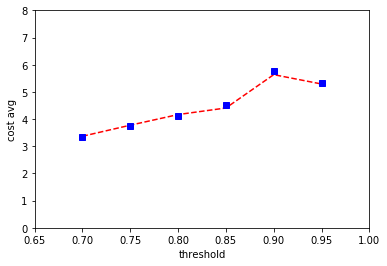

In [114]:
import matplotlib.pyplot as plt

x = np.arange(.7, .96, 0.05)
y1 = [
    3.368,
3.7748,
4.1662,
4.408,
5.6348,
5.2904
]

y2 = [
    3.357,
3.7311,
4.1262,
4.5134,
5.7857,
5.3294
]

#plt.plot(x, y, 'ro')
plt.plot(x, y1, 'r--', x, y2, 'bs')
plt.ylabel('cost avg')
plt.xlabel('threshold')
plt.axis([.65, 1, 0, 8])
plt.show()